# Relationship between age and income

The goal is to investigate the relationship between age and income using US census data. The target of inference is the linear regression coefficient when regressing yearly income in dollars on age, while controlling for sex. The data from California in the year 2019 is downloaded through the Folktables interface (1). Predictions of income are made by training a gradient boosting tree via XGBoost (2) on the previous year’s data.

1. F. Ding, M. Hardt, J. Miller, L. Schmidt, “Retiring adult: New datasets for fair machine learning” in Advances in Neural Information Processing Systems 34 (2021), pp. 6478–6490.
2. T. Chen, C. Guestrin, “XGBoost: A scalable tree boosting system” in Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2016), pp. 785–794.

### Import necessary packages

In [2]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq
from tqdm import tqdm
from utils import *

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [3]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [4]:
alpha = 0.05
coordinate = 0  # Choose between 0, 1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(100, 2000, 10).astype(
    int
)  # Test for different numbers of labeled incomes
num_trials = 100
# Compute ground truth
true_theta = OLS(Y_total, exog=X_total).fit().params[coordinate]

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [5]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
        )

        # Classical interval
        classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_ols_ci(X_total, Yhat_total, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]
print(df.head())

100%|██████████| 10/10 [08:32<00:00, 51.23s/it]

      method      n       lower        upper  trial        width
0        PPI  100.0  606.317745  1593.028232      0   986.710488
1  Classical  100.0  612.977171  1588.819185      0   975.842013
2        PPI  100.0  610.870252  1256.271302      1   645.401050
3  Classical  100.0  402.888153  1301.020825      1   898.132672
4        PPI  100.0  406.158883  1638.256074      2  1232.097191


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

          method       n       lower        upper  trial        width
0            PPI   100.0  606.317745  1593.028232      0   986.710488
1      Classical   100.0  612.977171  1588.819185      0   975.842013
2            PPI   100.0  610.870252  1256.271302      1   645.401050
3      Classical   100.0  402.888153  1301.020825      1   898.132672
4            PPI   100.0  406.158883  1638.256074      2  1232.097191
...          ...     ...         ...          ...    ...          ...
1996         PPI  2000.0  946.300662  1177.159697     98   230.859035
1997   Classical  2000.0  908.382372  1164.868137     98   256.485765
1998         PPI  2000.0  941.565844  1135.885358     99   194.319513
1999   Classical  2000.0  942.658330  1178.623749     99   235.965419
2000  Imputation     NaN  714.306163   721.809346      0     7.503183

[2001 rows x 6 columns]


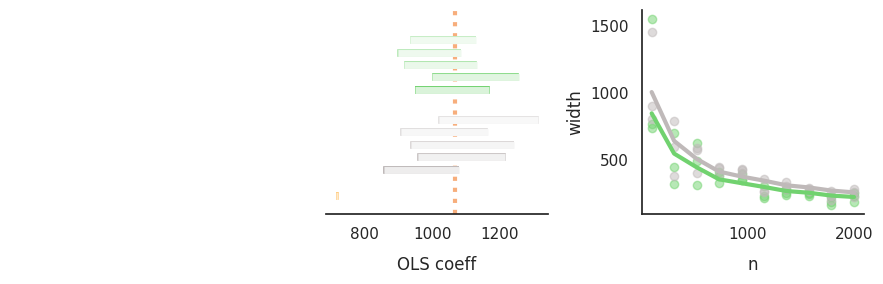

In [7]:
make_plots(
    df,
    "./plots/census_income.pdf",
    intervals_xlabel="OLS coeff",
    true_theta=true_theta,
)
print(df)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \theta^* < 800$.

In [6]:
# Find n such that we reject H0: OLS coeff < 800 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
        )

        if ppi_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

        if classical_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 100, 2000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 100, 2000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=547 labeled data points to reject the null.
The classical test requires n=818 labeled data points to reject the null.
